### Import packages & load data

In [1]:
!pip install -U statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.8 MB 4.0 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [2]:
!wget -nc https://lazyprogrammer.me/course_files/timeseries/perrin-freres-monthly-champagne.csv

--2022-10-08 23:10:59--  https://lazyprogrammer.me/course_files/timeseries/perrin-freres-monthly-champagne.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1598 (1.6K) [text/csv]
Saving to: ‘perrin-freres-monthly-champagne.csv’

perrin-freres-month 100%[===================>]   1.56K  --.-KB/s    in 0s      

2022-10-08 23:11:00 (31.0 MB/s) - ‘perrin-freres-monthly-champagne.csv’ saved [1598/1598]



In [3]:
!head perrin-freres-monthly-champagne.csv

Month,Perrin Freres monthly champagne sales millions ?64-?72
1964-01,2815
1964-02,2672
1964-03,2755
1964-04,2721
1964-05,2946
1964-06,3036
1964-07,2282
1964-08,2212
1964-09,2922


In [4]:
!tail perrin-freres-monthly-champagne.csv

1972-02,3564
1972-03,4577
1972-04,4788
1972-05,4618
1972-06,5312
1972-07,4298
1972-08,1413
1972-09,5877
,
Perrin Freres monthly champagne sales millions ?64-?72,


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import r2_score

In [6]:
df = pd.read_csv('perrin-freres-monthly-champagne.csv', index_col='Month', parse_dates=True,
                 skipfooter=2)  # ignores the last two junk lines at the end of the file
df.columns = ['Sales']
df.index.freq = df.index.inferred_freq
df.head()

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,Sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


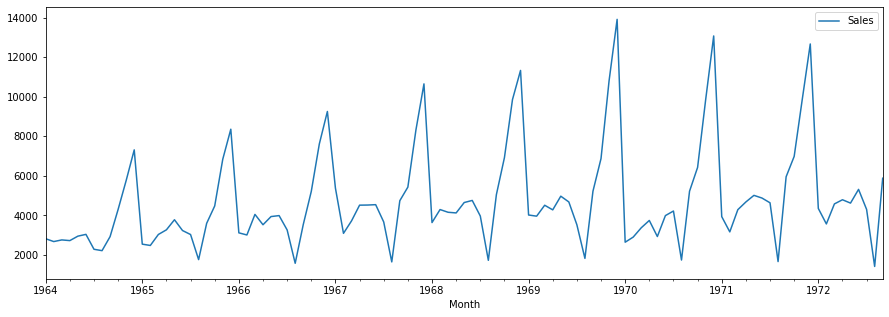

In [7]:
df.plot(figsize=(15,5));

### Functions for walkthrough validation and grid search

In [8]:
import itertools
import sklearn.metrics

def walkthrough(df, step_size, n_steps, scoring, **kwargs):
  Ntrain = len(df) - step_size - n_steps + 1
  score = []
  for end_train in range(Ntrain, len(df) - step_size + 1):
    df_train = df.iloc[:end_train]
    df_test = df.iloc[end_train: end_train + step_size]
    hw = ExponentialSmoothing(df_train, **kwargs)
    hw_res = hw.fit()
    score.append(scoring(hw_res.forecast(step_size), df_test))
  return np.mean(score)

def grid_search(df, params_grid, step_size, n_steps,
                scoring=sklearn.metrics.r2_score, greater_is_better=True):
  score_sign = +1 if greater_is_better else -1
  best_score = float('-inf')
  best_model = None
  for args in itertools.product(*params_grid.values()):
    kwargs = dict(zip(params_grid.keys(), args))
    score = walkthrough(df, step_size, n_steps, scoring, **kwargs)
    if score_sign * (score - best_score) > 0:
      best_model, best_score = kwargs, score
      print(f'Best {scoring.__name__} so far: {best_score:.4f}')
  return best_model, {scoring.__name__: best_score}

### Grid search with walkthrough validation

In [9]:
params_grid = {
  'initialization_method': ['legacy-heuristic', 'heuristic', 'estimated'],
  'trend': ['add', 'mul'],
  'damped_trend': [False, True],
  'seasonal': ['add', 'mul'],
  'seasonal_periods': [12],  # 1 year
  'use_boxcox': [False]  # Other choices generate error
}

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', RuntimeWarning)

best_model, best_score = grid_search(df['Sales'], params_grid, step_size=12, n_steps=10)
print('\nBest model:')
print(', '.join([f'{k}: {v:.4f}' for k,v in best_score.items()]))
for k,v in best_model.items():
  print(f'{k}: {v}')

Best r2_score so far: 0.9616
Best r2_score so far: 0.9699
Best r2_score so far: 0.9723
Best r2_score so far: 0.9724
Best r2_score so far: 0.9725

Best model:
r2_score: 0.9725
initialization_method: heuristic
trend: add
damped_trend: True
seasonal: mul
seasonal_periods: 12
use_boxcox: False


Train R2 =  0.93
Test  R2 =  0.98


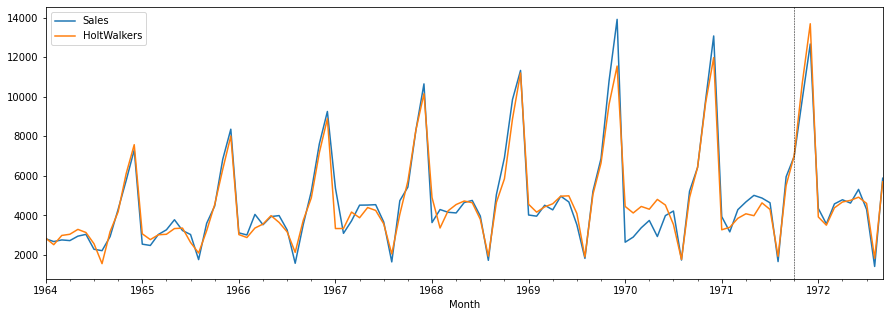

In [10]:
# Fit the best model to the data
Ntest = 12  # we want to test a full season (1 year)
df_train = df.iloc[:-Ntest]['Sales']
df_test = df.iloc[-Ntest:]['Sales']
hw = ExponentialSmoothing(df_train, **best_model)
hw_res = hw.fit()
# Score
hw_forecast = hw_res.forecast(Ntest)
print(f'Train R2 = {r2_score(df_train, hw_res.fittedvalues):5.2f}')
print(f'Test  R2 = {r2_score(df_test, hw_forecast):5.2f}')
# Plot
df['HoltWalkers'] = pd.concat([hw_res.fittedvalues, hw_forecast])
df.plot(figsize=(15,5));
plt.axvline(x=df.index[-Ntest], color='black', ls='--', lw=.5);